# Analysing election data using Pandas

Before you start you need Pandas/Numpy.
The best way to do this is to install Anaconda.

[Download here](https://www.continuum.io/downloads)


In [ ]:
import pandas as pd
import numpy as np


# Get the data

this is really easy with Pandas as you don't have to 
think about what file format you use. The source files
are available on different sites. 



[Election results here](https://www.data.gouv.fr/fr/datasets/election-presidentielle-des-23-avril-et-7-mai-2017-resultats-du-1er-tour-1/)

which gives the circonscriptions by code but not the GPS data.
So we will have to add this from another source

[Postal codes are available here](https://www.data.gouv.fr/fr/datasets/base-officielle-des-codes-postaux/)


This takes a bit of googling as they aren't well referenced.


# Gotchas

There are 2 parameters we have to set otherwise the data is FUBAR

1. The separator for the csv file - which isn't a comma **sep= ';'**
2. Skip the first 3 lines in the .xls as they are BS **skiprows=3**

In [4]:
dd = pd.read_csv( '/Users/macbuse/Desktop/ELECTIONS FRANCE/correspondance-code-insee-code-postal.csv', sep= ';'  )

In [5]:
pp = pd.read_excel('/Users/macbuse/Desktop/ELECTIONS FRANCE/Presidentielle_2017_Resultats_Communes_Tour_1.xls',
                   skiprows=3)

# Dipping in

We can get a view of the first few lines just to see what the column names are.<br>
Then we can access column data:

- using that name by copy paste
- or by  an index 

In [8]:
dd[:3]


,Code INSEE,Code Postal,Commune,Département,Région,Statut,Altitude Moyenne,Superficie,Population,geo_point_2d,geo_shape,ID Geofla,Code Commune,Code Canton,Code Arrondissement,Code Département,Code Région
0,32460,32720,VERGOIGNAN,GERS,MIDI-PYRENEES,Commune simple,126,1056,0.3,"43.7235746425, -0.188266221507","{""type"": ""Polygon"", ""coordinates"": [[[-0.19884...",34962,460,24,3,32,73
1,51141,51240,LA CHAUSSEE-SUR-MARNE,MARNE,CHAMPAGNE-ARDENNE,Commune simple,130,2240,0.7,"48.8433156105, 4.54286173009","{""type"": ""Polygon"", ""coordinates"": [[[4.504753...",18178,141,33,4,51,21
2,77130,77580,COULOMMES,SEINE-ET-MARNE,ILE-DE-FRANCE,Commune simple,136,371,0.4,"48.8919104938, 2.92942534432","{""type"": ""Polygon"", ""coordinates"": [[[2.940606...",31737,130,8,1,77,11


# Extracting a subset of the data

- we aren't going to need all the data so we will select some columns by index.
- we will also rename some columns so that it matches with the GPS data





In [ ]:
cols = [0,2]
cols.extend([20 + 7 *k for k in range(5)])

pp.rename(columns={u'Code du département': 'Code Département',
                    'Code de la commune' :'Code Commune'},
                    inplace=True)
results = pp[cols]
results.sort_values(by=['Code Département','Code Commune'], ascending=[True, True])[:5]

and the GPS data looks like this

In [9]:
gps = dd[['Code Département', 'Code Commune','geo_point_2d']]
gps.sort_values(by=['Code Département', 'Code Commune'], ascending=[True, True])[:3]

,Code Département,Code Commune,geo_point_2d
28626,01,1,"46.1534255214, 4.92611354223"
34845,01,2,"46.0091878776, 5.42801696363"
22048,01,4,"45.9608475114, 5.3729257777"


# Getting longitude and latitude

The **geo_point_2d** data is a string so we have to split this
and convert the result to floatting point.
Actually we make a list 
- with entries( hash , [longitude, latitude]) 
- the hash is  **'Code Département' + 'Code Commune'** 


In [22]:
gps2 = [ (str(x['Code Département']) +  str(x['Code Commune']), 
                                     [ float(t) for t in x['geo_point_2d'].split(',')] ) for ix, x in gps.iterrows() ]

...now we have to creata a lookup table for the coordinates. <br>
This is a Python dictionnary







In [23]:
gps2 = dict(gps2)

# Making new columns

## First we have to prepare the data

Now we have to make lists which contain the 
column data for longitudes and latitudes.

If there is no entry corresponding to the hash
then set the entry to **nan = not a number**


In [25]:

gps_col = []
for ix,x in results.iterrows():
    dc = str(x['Code Département'])
    #add a preceding 0 if single digit
    if len(dc) < 2:
        dc = '0' + dc
        
    kk =  dc +  str(x['Code Commune']) 
    #hash not found
    if kk not in gps2:
        gps_col.append([float('nan')]*2)
        continue
    gps_col.append(gps2[kk])

lng,lat = zip(*gps_col)

## adding columns
adding the columns is simple 

In [27]:
results.loc[:,'long'] = pd.Series(lng, index=results.index)
results.loc[:,'lat'] = pd.Series(lat, index=results.index)

and lets look at things to see they are OK

In [34]:
results[:3]


,Code Département,Code Commune,Nom,Nom.1,Nom.2,Nom.3,Nom.4,long,lat
0,1,1,LE PEN,MACRON,FILLON,MÉLENCHON,DUPONT-AIGNAN,46.153426,4.926114
1,1,2,LE PEN,MACRON,FILLON,MÉLENCHON,HAMON,46.009188,5.428017
2,1,4,LE PEN,MÉLENCHON,MACRON,FILLON,DUPONT-AIGNAN,45.960848,5.372926


# Extraction and plotting 

Now we can extract data for plotting by asking the 
dataframe nicely for those  circonsriptions where 
a particular candidate **X** won like this :

results.loc[(results['Nom'] == **X** )  & (results['long'] != nan)]



In [43]:
nan = float('nan')
ham = results.loc[(results['Nom'] == u'HAMON')  & (results['long'] != nan)]
fil = results.loc[(results['Nom'] == u'FILLON')  & (results['long'] != nan)]

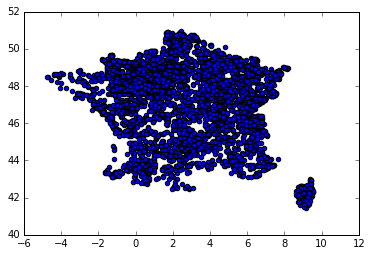

In [45]:
import matplotlib.pylab as plt

%matplotlib inline
# and drop na rows if any of the columns are NA
mydata = fil[["lat", "long"]].dropna(how="any")
# Now plot with matplotlib
vals = mydata.values
plt.scatter(vals[:, 0], vals[:, 1])

plt.axes().set_aspect('equal', 'datalim')


# Geometric data 

There is actually a geometric representation of 
each circonscription that is easy to plot. <br>
It should be possible to look for possible
**gerrymandering** using this.

There are already projects in the US :  [Metric geometry](https://sites.tufts.edu/gerrymandr/resources/)

*This site is devoted to the Metric Geometry and Gerrymandering Group run by Moon Duchin on understanding apportionment, districting, and gerrymandering as problems at the intersection of law, civil rights, and mathematics (particularly metric geometry).  Here is a partial reading list with a focus on shapes of U.S. Congressional Districts.*


In [47]:
dd['geo_shape'][0]

'{"type": "Polygon", "coordinates": [[[-0.198840174520842, 43.70794322452202], [-0.222235915236875, 43.71887029533192], [-0.19414330237234, 43.737016685694684], [-0.180792917516703, 43.73392241336569], [-0.166464609500636, 43.74073425722042], [-0.158609760122906, 43.733001456816694], [-0.165604514951094, 43.72182035935971], [-0.17757883861499, 43.71205146251945], [-0.198840174520842, 43.70794322452202]]]}'

the best way to extract the data is to read it to store it to a variable using **exec**

In [52]:
exec('mpoly=' + dd['geo_shape'][1])
lon, lat = zip(*mpoly['coordinates'][0])

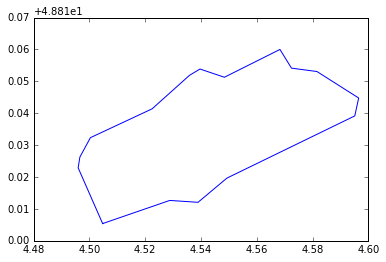

In [53]:

plt.plot(lon,lat)

In [118]:
#dd.sort_values(by=['Code Département', 'Code Commune'], ascending=[True, True])[:3]

# Lets look at Paris
using the department number = 75

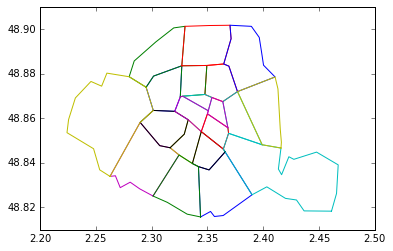

In [120]:
vv  = dd.loc[(dd['Code Département'] == '75')]
for x in vv['geo_shape'][:]:
    exec('mm=' + x)
    lon, lat = zip(*mm['coordinates'][0])
    plt.plot(lon,lat)


In [102]:
vv  = dd.loc[(dd['Code Département'] == '75')]
vv[:4]

,Code INSEE,Code Postal,Commune,Département,Région,Statut,Altitude Moyenne,Superficie,Population,geo_point_2d,geo_shape,ID Geofla,Code Commune,Code Canton,Code Arrondissement,Code Département,Code Région
441,75108,75008,PARIS-8E-ARRONDISSEMENT,PARIS,ILE-DE-FRANCE,Chef-lieu canton,39,385,40.3,"48.8725272666, 2.31258256042","{""type"": ""Polygon"", ""coordinates"": [[[2.320781...",9859,108,22,1,75,11
525,75117,75017,PARIS-17E-ARRONDISSEMENT,PARIS,ILE-DE-FRANCE,Chef-lieu canton,40,563,168.5,"48.8873371665, 2.30748555949","{""type"": ""Polygon"", ""coordinates"": [[[2.295145...",36583,117,31,1,75,11
1676,75110,75010,PARIS-10E-ARRONDISSEMENT,PARIS,ILE-DE-FRANCE,Chef-lieu canton,45,288,95.9,"48.8760285569, 2.36111290456","{""type"": ""Polygon"", ""coordinates"": [[[2.363856...",8429,110,24,1,75,11
4049,75111,75011,PARIS-11E-ARRONDISSEMENT,PARIS,ILE-DE-FRANCE,Chef-lieu canton,43,366,152.7,"48.8594154976, 2.37874106024","{""type"": ""Polygon"", ""coordinates"": [[[2.399114...",36586,111,25,1,75,11


In [189]:
#shoelace formula for area
#http://stackoverflow.com/questions/24467972/calculate-area-of-polygon-given-x-y-coordinates
def area_np(M):        
    x, y = M.transpose()
    n = len(x)
    shift_up = np.arange(-n+1, 1)
    shift_down = np.arange(-1, n-1)    
    return abs( (x * (y.take(shift_up) - y.take(shift_down))).sum() / 2.0 )

def PolyArea(M):
    x, y = M.transpose()
    return 0.5*np.abs(np.dot(x,np.roll(y,1))-np.dot(y,np.roll(x,1)))

def perimeter(M):
    return sum ( np.linalg.norm(x) for x in (np.roll(M,1, axis=0) - M ) )
    


# Test on one example

In [193]:
DD = np.array(mm['coordinates'][0])
perimeter(DD)**2/ PolyArea(DD) 

17.587809962271962

# Calculate isoperimetric constant for a department

using the above functions we can define some more stuff

In [331]:
def isoperimetric_coeff(dept):
    vv  = dd.loc[(dd['Code Département'] == dept)]
    communes = []
    for ix,ff in vv.iterrows():
        x = ff['geo_shape']
        exec('mm=' + x)
        DD = np.array( mm['coordinates'][0])
        communes.append( ( perimeter(DD)**2/ PolyArea(DD)/4/np.pi, ff['Commune'] , x) )
    return communes


In [323]:
communes.sort()

In [327]:
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection

def show_isoperimetric_data(communes):
    fig, ax = plt.subplots()
    patches = []

    #we have to calculate the bounding box ourselves
    left = 100
    right = 0
    top = 0
    bottom = 100

    for score, name, shape in communes[:]:

        exec('mm=' + shape)
        DD = np.array( mm['coordinates'][0])

        x,y = DD.transpose()
        left = min(left,min(x))
        right = max(right,max(x))
        bottom = min(bottom ,min(y))
        top = max(top,max(y))

        polygon = Polygon( DD, True)
        #calculate color lighter is worse
        fc = (score - 1)/2
        if fc > 1: fc = 1.
        polygon.set_facecolor( (fc,fc,0))
        ax.add_patch(polygon)


    p = PatchCollection(patches)

    ax.set_xlim(left, right)
    ax.set_ylim(bottom, top)
    ax.add_collection(p)
    ax.set_aspect('equal', 'datalim')


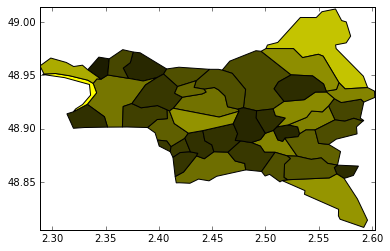

In [332]:
show_isoperimetric_data(isoperimetric_coeff('93'))

voila for the 93

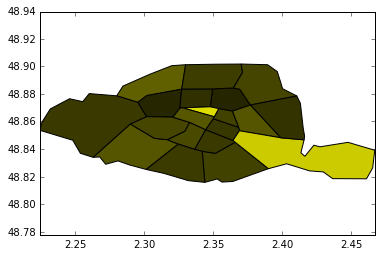

In [334]:
show_isoperimetric_data(isoperimetric_coeff('75'))

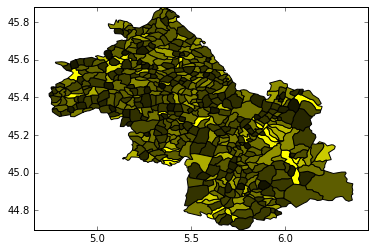

In [335]:
show_isoperimetric_data(isoperimetric_coeff('38'))